# ANN VE Map inference training and validation

*Import needed packages*

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

*Import training data*

In [2]:
raw_train_data_pt1 = pd.read_csv('train_split1.csv', sep=';')
raw_train_data_pt2 = pd.read_csv('train_split2.csv', sep=';')
raw_train_data = pd.concat([raw_train_data_pt1, raw_train_data_pt2])
raw_train_data = raw_train_data.drop(columns=raw_train_data.columns[0])
raw_train_data

,Offset,Engine RPM (SAE),Knock Retard Degree Short Term,Knock Retard Degree Long Term,Accelerator Pedal Position Sensor Voltage,Throttle Position (SAE) %,Relative Throttle Position (SAE) %,Commanded Throttle Actuator (SAE) %,Fuel System #1 Status (SAE),Fuel System #2 Status (SAE),...,Equivalence Ratio Commanded (SAE) lambda,Total Airflow g/s,Total Volumetric Efficiency Bank 1 %,Base Volumetric Efficiency Bank 1 %,Intake Manifold Absolute Pressure (SAE) kPa,Fuel Mass Cyl 1 Gramm,Pressure Ratio,Long Term Fuel Trim Bank 2 (SAE) %,Aircharge mg,Injector Pulse Mode
0,7.836,2.896040,0.0,0,0.0,15.294118,5.182161,2.030612,OL - Not Ready,OL - Not Ready,...,1.895226,2.008789,78.515625,75.488281,93.615132,0.000000,0.992188,0.78125,0.0,Normal
1,7.860,8.242574,0.0,0,0.0,15.218529,5.098039,1.836092,OL - Not Ready,OL - Not Ready,...,1.855948,1.559570,78.515625,75.488281,93.378289,0.000000,0.992188,0.78125,0.0,Normal
2,7.884,13.589109,0.0,0,0.0,15.078981,5.016903,1.568627,OL - Not Ready,OL - Not Ready,...,1.816669,1.480469,78.515625,75.488281,93.141447,0.000000,0.984375,0.78125,0.0,Normal
3,7.910,19.381188,0.0,0,0.0,14.927803,4.866222,1.568627,OL - Not Ready,OL - Not Ready,...,1.774117,1.781250,78.417969,75.390625,92.884868,0.000000,0.984375,0.78125,0.0,Normal
4,7.937,25.396040,0.0,0,0.0,14.770811,4.709746,1.568627,OL - Not Ready,OL - Not Ready,...,1.729929,2.159180,78.222656,75.195312,92.618421,0.000000,0.973633,0.78125,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130270,7546.807,641.000000,0.0,0,0.0,11.764706,1.568627,1.568627,CL - Normal,CL - Normal,...,1.000000,5.293945,62.304688,60.839844,26.000000,0.008672,0.266602,0.78125,125.6,Unknown
130271,7546.833,641.000000,0.0,0,0.0,11.764706,1.568627,1.568627,CL - Normal,CL - Normal,...,1.000000,5.298828,62.304688,60.839844,26.000000,0.008656,0.266602,0.78125,125.6,Unknown
130272,7546.864,641.000000,0.0,0,0.0,11.764706,1.568627,1.568627,CL - Normal,CL - Normal,...,1.000000,5.298828,62.304688,60.839844,26.000000,0.008578,0.266602,0.78125,125.4,Unknown
130273,7546.889,641.000000,0.0,0,0.0,11.764706,1.568627,1.568627,CL - Normal,CL - Normal,...,1.000000,5.298828,62.304688,60.839844,26.000000,0.008656,0.266602,0.78125,125.6,Unknown


*Prepare data, omit noise and unnecessary columns*

In [3]:
filtered_training_data = raw_train_data.iloc[8400:,[1, 5, 10, 19, 21, 22, 23, 24, 28, 29, 30, 31, 32, 33, 37, 38, 39, 40, 41, 42, 44]]

renamed_training_data = filtered_training_data.rename(columns={'Engine RPM (SAE)': 'rpm',
                                        'Throttle Position (SAE) %': 'throttle_percent',
                                        'Injector Pulse Width Average ms': 'inj_pulse_width_avg_ms',
                                        'Timing Advance Degree (SAE)': 'timing_advance_deg',
                                        'Total Knock Retard Degree': 'total_knock_ret_deg',
                                        'Idle Desired RPM': 'idle_desired_rpm',
                                        'Vehicle Speed (SAE) km/h': 'kmh',
                                        'Absolute Load (SAE) %': 'absolute_load_percent',
                                        'Exhaust Gas Temperature C°': 'exh_temp_celsius',
                                        'Engine Coolant Temp (SAE) C°': 'coolant_temp_celsius',
                                        'Intake Air Temp (SAE) C°': 'intake_air_temp_celsius',
                                        'Manifold Air Temp C°': 'manifold_air_temp_celsius',
                                        'Barometric Pressure kPa': 'barometric_pressure_kpa',
                                        'Ambient Air Temp (SAE) C°': 'ambient_air_temp_celsius',
                                        'Total Airflow g/s': 'total_airflow_grampersecond',
                                        'Total Volumetric Efficiency Bank 1 %': 'total_ve_bank_1_percent',
                                        'Base Volumetric Efficiency Bank 1 %': 'base_ve_bank_1_percent',
                                        'Intake Manifold Absolute Pressure (SAE) kPa': 'absolute_in_manifold_pressure_kpa',
                                        'Fuel Mass Cyl 1 Gramm': 'fuel_mass_cyl1_gramm',
                                        'Pressure Ratio': 'pratio',
                                        'Aircharge mg': 'aircharge_milligram'})


renamed_training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252149 entries, 8400 to 130274
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   rpm                                252149 non-null  float64
 1   throttle_percent                   252149 non-null  float64
 2   inj_pulse_width_avg_ms             252149 non-null  float64
 3   timing_advance_deg                 252149 non-null  float64
 4   Fuel Level Input (SAE) %           252149 non-null  float64
 5   idle_desired_rpm                   252149 non-null  int64  
 6   kmh                                252149 non-null  float64
 7   absolute_load_percent              252149 non-null  float64
 8   exh_temp_celsius                   252149 non-null  float64
 9   coolant_temp_celsius               252149 non-null  float64
 10  intake_air_temp_celsius            252149 non-null  float64
 11  manifold_air_temp_celsius          252149

* Correlation Heatmap

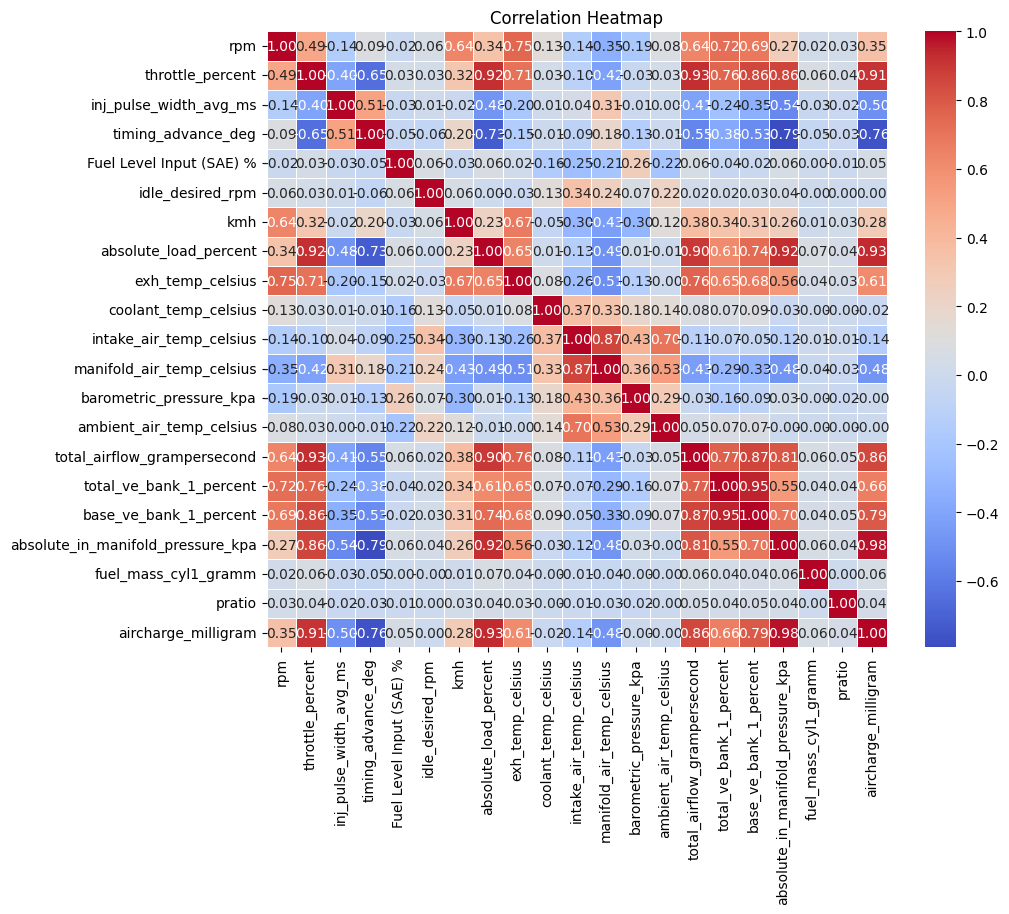

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = renamed_training_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

*Creating final dataset for training and validation*

In [5]:
correlation_dataset = renamed_training_data[['rpm', 'exh_temp_celsius',
                                             'total_airflow_grampersecond', 'aircharge_milligram', 'base_ve_bank_1_percent']]

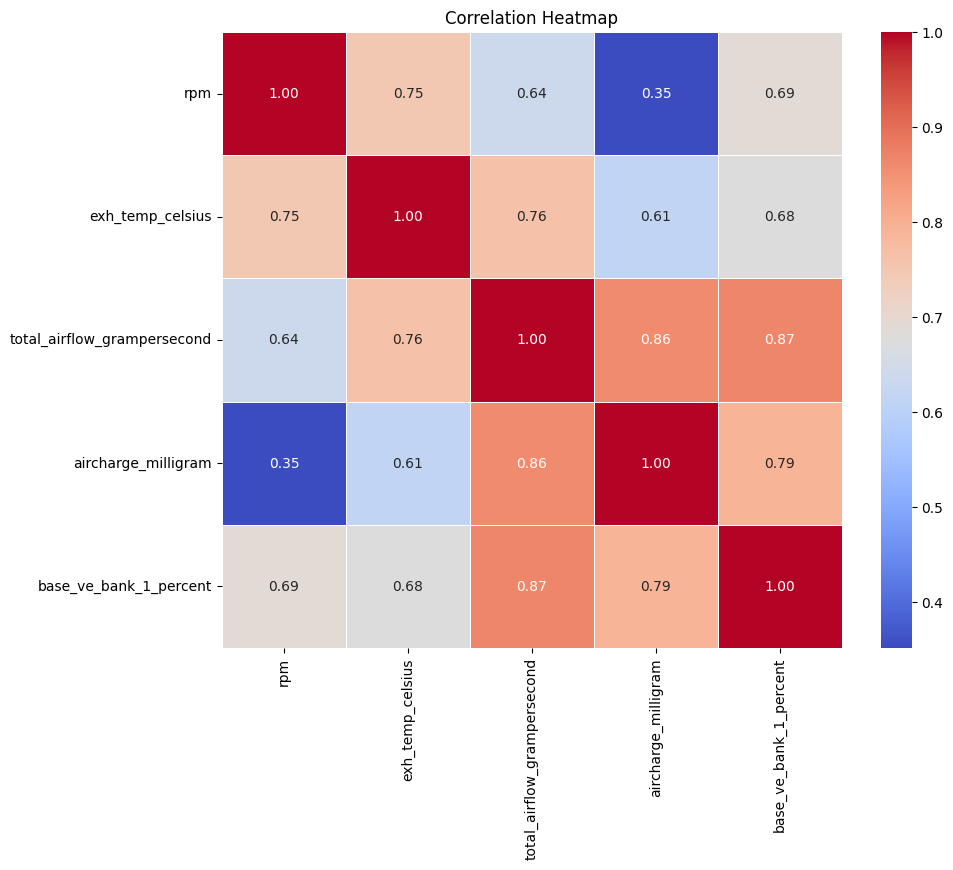

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = correlation_dataset.corr()

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

*Neural Network Data Preprocessing*

In [7]:
data_cleaned = correlation_dataset
# Split features and target
X = data_cleaned.drop(columns=['base_ve_bank_1_percent'])
y = data_cleaned['base_ve_bank_1_percent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

*Define Neural Network Model*

In [8]:
class VEModel(nn.Module):
    def __init__(self, input_size):
        super(VEModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

*Initializing model and defining Loss function + optimizer*

In [9]:
input_size = X_train_tensor.shape[1]
model = VEModel(input_size)

# Loss function and optimizer
criterion = nn.HuberLoss()
# learning rate in the begining is pretty high, but the scheduler takes care of it, probably some optimization needed
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.8)
input_size

4

*Model training function*

In [10]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Print average loss after each epoch
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')
        scheduler.step(epoch_loss)
        current_lr = scheduler.get_last_lr()
        print(f"Current Learning Rate: {current_lr}")
        

*Model eval function*

In [11]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Validation Loss: {avg_test_loss:.4f}')

*Training the model*

In [12]:
train_model(model, train_loader, criterion, optimizer, epochs=300)

Epoch [1/300], Loss: 30.0140
Current Learning Rate: [0.01]
Epoch [2/300], Loss: 1.7673
Current Learning Rate: [0.01]
Epoch [3/300], Loss: 0.6378
Current Learning Rate: [0.01]
Epoch [4/300], Loss: 0.5707
Current Learning Rate: [0.01]
Epoch [5/300], Loss: 0.4485
Current Learning Rate: [0.01]
Epoch [6/300], Loss: 0.3542
Current Learning Rate: [0.01]
Epoch [7/300], Loss: 0.3085
Current Learning Rate: [0.01]
Epoch [8/300], Loss: 0.2898
Current Learning Rate: [0.01]
Epoch [9/300], Loss: 0.2838
Current Learning Rate: [0.01]
Epoch [10/300], Loss: 0.2803
Current Learning Rate: [0.01]
Epoch [11/300], Loss: 0.2784
Current Learning Rate: [0.01]
Epoch [12/300], Loss: 0.2810
Current Learning Rate: [0.01]
Epoch [13/300], Loss: 0.2707
Current Learning Rate: [0.01]
Epoch [14/300], Loss: 0.2710
Current Learning Rate: [0.01]
Epoch [15/300], Loss: 0.2654
Current Learning Rate: [0.01]
Epoch [16/300], Loss: 0.2638
Current Learning Rate: [0.01]
Epoch [17/300], Loss: 0.2574
Current Learning Rate: [0.01]
Epoch

*Evaluating the model*

In [13]:
evaluate_model(model, test_loader, criterion)

Validation Loss: 0.1596


*Inference and visualization test*
* Unseen data still needed to make sure model is generalizing properly

In [ ]:
# columns in the order used during training
FEATURES = ['rpm', 'exh_temp_celsius', 'total_airflow_grampersecond', 'aircharge_milligram']
TARGET   = 'base_ve_bank_1_percent'  # optional, if you want error maps/metrics

model.eval()

# scale inputs exactly like during training
X_np_raw = X_test.to_numpy().astype(np.float32)
X_np = scaler.transform(X_np_raw).astype(np.float32)

with torch.no_grad():
    X_t = torch.from_numpy(X_np)
    y_pred = model(X_t).squeeze(-1).cpu().numpy() 

y_pred

In [15]:
# Axes from unscaled test features
rpm        = X_np_raw[:, 0]
exh_temp   = X_np_raw[:, 1]
airflow_gs = X_np_raw[:, 2]
aircharge  = X_np_raw[:, 3]

Z = np.asarray(y_pred, dtype=np.float32)

# Clip for nicer colorbar
Z = np.clip(Z, 0, 140)


*Visualization*

/var/folders/zg/003k70h94cndfcy2n8s4m7hr0000gn/T/ipykernel_68901/2151512146.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grid = df.groupby([pd.cut(df.aircharge, load_edges),


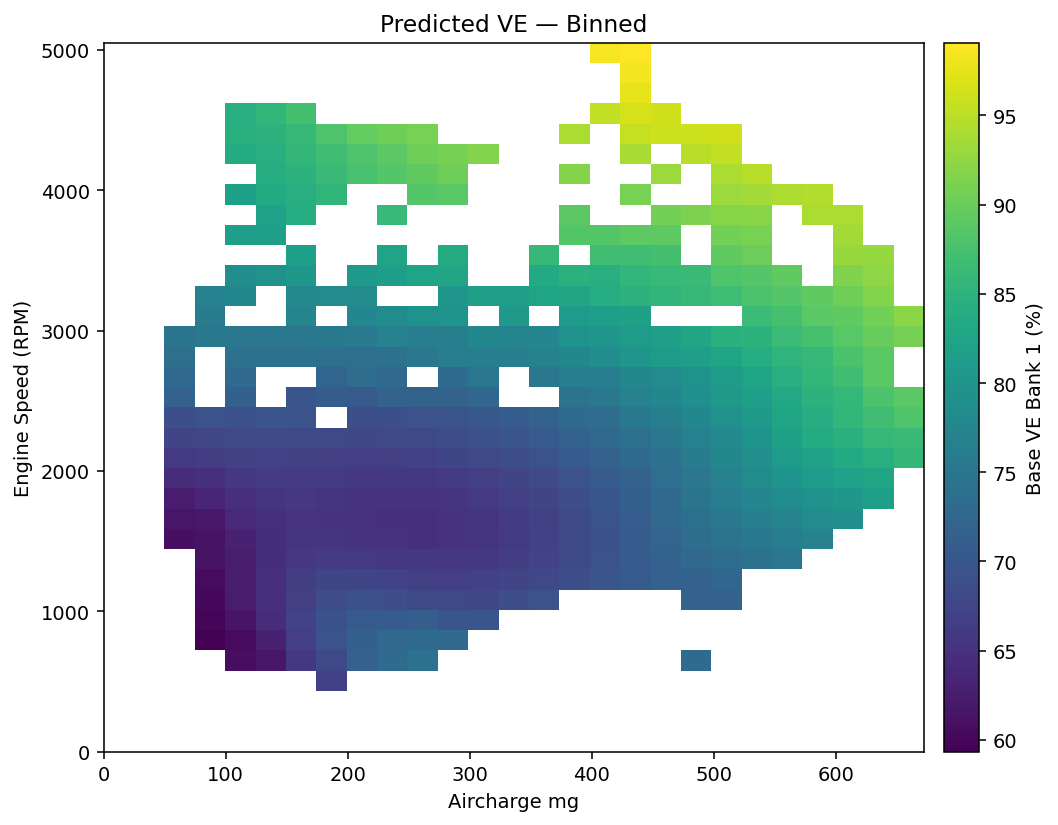

In [16]:
df = pd.DataFrame({
    "rpm": rpm,
    "aircharge": aircharge,
    "ve": Z
})

rpm_edges  = np.linspace(df.rpm.min(), df.rpm.max(), 36)
load_edges = np.linspace(df.aircharge.min(), df.aircharge.max(), 28)

grid = df.groupby([pd.cut(df.aircharge, load_edges),
                   pd.cut(df.rpm, rpm_edges)])["ve"].mean().unstack()

plt.figure(figsize=(8,6), dpi=140)
pc = plt.pcolormesh(load_edges, rpm_edges, grid.values.T, shading="auto")
plt.colorbar(pc, pad=0.02).set_label("Base VE Bank 1 (%)")
plt.xlabel("Aircharge mg")
plt.ylabel("Engine Speed (RPM)") 
plt.title("Predicted VE — Binned")
plt.tight_layout()
plt.show()


*Saving model, scaler and features including their order*

In [ ]:
# model.eval().cpu()
# example = torch.randn(1, 4)
# scripted = torch.jit.trace(model, example)
# scripted.save("vemodel_scripted.pt")

In [ ]:
# import joblib, json

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# joblib.dump(scaler, "x_scaler.pkl")

# FEATURES = list(X.columns)
# with open("features.json","w") as f:
#     json.dump(FEATURES, f)